### Spectral Synthesis & Emission-Line Fitting

The purpose of this notebook is to sandbox a new spectral synthesis fitting code.

In [157]:
import os, scipy, pdb
import numpy as np 
import fitsio
import multiprocessing

In [2]:
from astropy.table import Table
import desispec.io

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-68nr4c5p because the default path (/homedir/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Top-level directories. Need to remember to move the script CKC2fits.py into a repository somewhere.

In [124]:
ssppath = os.path.join(os.getenv('DESI_ROOT'), 'users', 'ioannis', 'fsps') # need a variable for this
truthdir = os.path.join(os.getenv('DESI_ROOT'), 'sv', 'vi', 'TruthTables')
specprod_dir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'redux', 'andes')

### Templates

In [227]:
def _smooth_and_resample(args):
    """Wrapper for the multiprocessing."""
    return smooth_and_resample(*args)

def smooth_and_resample(sspflux, sspwave, wave, resolution_data):
    """
    sspflux[npix] - redshifted SSP template
    sspwave[npix] - redshifted SSP wavelength
    
    """
    from desispec.resolution import Resolution
    from desispec.interpolation import resample_flux
        
    R = Resolution(resolution_data)
    return R.dot(resample_flux(wave, sspwave, sspflux))

class CKCz14(object):
    """Class to handle the CKCz14 SSPs.
    
    The SSPs have been converted to FITS format using the script fsps2fits.py
    
    """
    def __init__(self, metallicity='Z0.0190', minwave=0.0, maxwave=1e4, verbose=True):
        from astropy.table import Table
        from astropy.cosmology import FlatLambdaCDM

        self.cosmo = FlatLambdaCDM(H0=70, Om0=0.3)        

        self.metallicity = metallicity
        self.Z = float(metallicity[1:])
        self.library = 'CKC14z'
        self.isochrone = 'Padova' # would be nice to get MIST in here
        self.imf = 'Kroupa'

        # Don't hard-code the path!
        self.ssppath = '/global/cfs/cdirs/desi/users/ioannis/fsps'
        self.sspfile = os.path.join(ssppath, self.library, 'SSP_{}_{}_{}_{}.fits'.format(
            self.isochrone, self.library, self.imf, self.metallicity))

        if verbose:
            print('Reading {}'.format(self.sspfile))
        wave = fitsio.read(self.sspfile, ext='WAVE')
        flux = fitsio.read(self.sspfile, ext='FLUX')
        
        keep = np.where((wave >= minwave) * (wave <= maxwave))[0]
        self.wave = wave[keep]
        self.flux = flux[keep, :]
        self.info = Table(fitsio.read(self.sspfile, ext='METADATA'))

        self.nage = len(self.info['age'])
        self.npix = len(wave)
        
    def smooth_and_resample(self, specobj, zbest, iobj=0, nproc=1):
        """
        iobj - index of object of interest
        specobj (desispec.spectra.Spectra)
        zbest (astropy.table.Table) - redshift table
        
        """
        oneplusz = 1 + zbest['Z'][iobj]
                    
        # loop over cameras then SSP ages
        smoothflux = []
        for camera in ('b', 'r', 'z'):
            args = [(self.flux[:, ii] / oneplusz, self.wave * oneplusz, specobj.wave[camera], 
                     specobj.resolution_data[camera][iobj]) for ii in np.arange(self.nage)]
            with multiprocessing.Pool(nproc) as pool:
                smoothflux.append(np.array(pool.map(_smooth_and_resample, args)).T)

        return np.concatenate((smoothflux[0], smoothflux[1], smoothflux[2]), axis=0)
        
ssp = CKCz14(metallicity='Z0.0190')

Reading /global/cfs/cdirs/desi/users/ioannis/fsps/CKC14z/SSP_Padova_CKC14z_Kroupa_Z0.0190.fits


### Read the data

In [198]:
def get_data(tile='66003', night='20200315'):
    """ELG - tile='70005', night='20200228'
    
    https://desi.lbl.gov/trac/wiki/SurveyValidation/TruthTables
    """
    from astropy.table import join, vstack
    from desispec.spectra import Spectra

    datadir = os.path.join(specprod_dir, 'tiles', tile, night)
    
    print('Working on tile, night {}, {}'.format(tile, night))

    if tile == '66003':
        truthfile = os.path.join(truthdir, 'truth_table_BGS_v1.2.csv')
    elif tile == '70500':
        truthfile = os.path.join(truthdir, 'truth_table_ELG_v1.2_latest.csv')
    else:
        raise ValueError('Fix me.')
    truth = Table.read(truthfile)
    best = np.where(
        (truth['best quality'] >= 2.5) * 
        (truth['Redrock spectype'] == 'GALAXY') *
        (truth['Redrock z'] < 0.75) 
    )[0]
    #goodobj = np.where((zb['DELTACHI2'] > 100) * (zb['ZWARN'] == 0) * (zb['SPECTYPE'] == 'GALAXY'))[0]
    
    print('Read {}/{} good redshifts from {}'.format(len(best), len(truth), truthfile))
    truth = truth[best]
    
    zbest = []
    spectra, keepindx = [], []
    for spectro in ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'):
        zbestfile = os.path.join(datadir, 'zbest-{}-{}-{}.fits'.format(spectro, tile, night))
        coaddfile = os.path.join(datadir, 'coadd-{}-{}-{}.fits'.format(spectro, tile, night))
        if os.path.isfile(zbestfile) and os.path.isfile(coaddfile):
            zb = Table(fitsio.read(zbestfile))
            keep = np.where(np.isin(zb['TARGETID'], truth['TARGETID']))[0]
            print('Spectrograph {}: N={}'.format(spectro, len(keep)))
            if len(keep) > 0:
                zbest.append(zb[keep])
                keepindx.append(keep)
                spectra.append(desispec.io.read_spectra(coaddfile))

    if len(zbest) == 0:
        raise ValueError('No spectra found for tile {} and night {}!'.format(tile, night))
        
    # combine the spectrographs
    zbest = vstack(zbest)

    coadd = None
    for camera in ('b', 'r', 'z'):
        wave = spectra[0].wave[camera]
        fm, flux, ivar, mask, res = [], [], [], [], []
        for ii in np.arange(len(spectra)):
            fm.append(spectra[ii].fibermap[keepindx[ii]])
            flux.append(spectra[ii].flux[camera][keepindx[ii], :])
            ivar.append(spectra[ii].ivar[camera][keepindx[ii], :])
            mask.append(spectra[ii].mask[camera][keepindx[ii], :])
            res.append(spectra[ii].resolution_data[camera][keepindx[ii], :, :])

        fm = vstack(fm)
        flux = np.concatenate(flux)
        ivar = np.concatenate(ivar)
        mask = np.concatenate(mask)
        res = np.concatenate(res)

        _coadd = Spectra([camera], {camera: wave}, {camera: flux}, {camera : ivar}, 
                    resolution_data={camera: res}, mask={camera: mask}, 
                    fibermap=fm, single=True)#, meta=meta)    
        if coadd is None:
            coadd = _coadd
        else:
            coadd.update(_coadd)

    return zbest, coadd

In [199]:
# https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=5720;filename=DESI_data_042820.pdf;version=1
#zb, specobj = get_data(tile='66003', night='20200315') 
#zb, specobj, goodobj = get_data(tile='70005', night='20200228') # ELG tile
zb, specobj = get_data(tile='66003', night='20200315') # BGS+MWS tile

Read 2155/2241 good redshifts from /global/cfs/cdirs/desi/sv/vi/TruthTables/truth_table_BGS_v1.2.csv
Spectrograph 0: N=274
Spectrograph 1: N=244
Spectrograph 2: N=127
Spectrograph 3: N=238
Spectrograph 4: N=111
Spectrograph 5: N=253
Spectrograph 6: N=275
Spectrograph 7: N=233
Spectrograph 8: N=260
Spectrograph 9: N=140


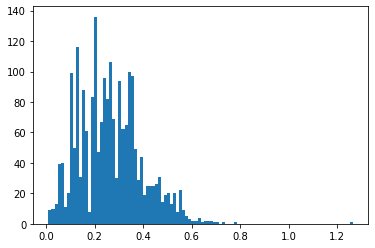

In [200]:
_ = plt.hist(zb['Z'], bins=100)

In [217]:
ww = np.where(zb['Z'] < 0.1)[0]
print(ww)
zb[ww]

[   3   11   44   56   85   98  104  105  113  137  140  142  145  147
  194  206  231  253  277  288  311  321  334  366  368  461  467  493
  496  517  575  580  594  626  633  654  657  721  725  734  740  762
  777  778  787  815  821  842  881  882  885  901  912  917  920  927
 1020 1085 1154 1162 1165 1172 1204 1217 1236 1254 1255 1257 1267 1274
 1280 1337 1343 1362 1422 1444 1446 1453 1456 1463 1470 1483 1484 1486
 1512 1541 1549 1560 1564 1574 1575 1588 1590 1596 1598 1610 1614 1615
 1626 1628 1631 1651 1653 1668 1676 1680 1704 1726 1729 1731 1732 1745
 1747 1749 1751 1762 1772 1773 1778 1786 1820 1841 1847 1849 1850 1854
 1857 1859 1862 1864 1869 1874 1876 1882 1885 1886 1892 1893 1894 1911
 1927 1965 1967 1968 1971 1973 1994 2001 2006 2022 2032 2043 2047 2055
 2060 2072 2090 2095 2096 2097 2104 2127 2144]


TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32
35191325326313983,9540.85826280713,666.5421739670386 .. 35.73752467606016,0.021251042067577414,3.521659506053375e-06,0,7928,GALAXY,,10,1343.1988827884197,0,1
35191325330508031,10362.578732341528,860.4240668813793 .. 38.30302888891182,0.08682345727211192,6.100471086535081e-06,0,7929,GALAXY,,10,1912.6868509948254,0,1
35191328597869309,9463.848334237933,556.9767512005826 .. 24.64836993618624,0.04748949568772229,5.306667264465084e-06,0,7928,GALAXY,,10,817.9715269356966,0,1
35191328597871009,23375.065472722054,10196.613855908648 .. 635.8914857208673,0.06459996017551281,8.292737126796283e-06,0,7929,GALAXY,,10,35549.84364805557,0,1
35191328602065927,11493.930081903934,419.25747405426205 .. -25.144097616633292,0.08218008573679633,4.865171980766969e-06,0,7916,GALAXY,,10,5160.235840976238,0,1
35191328606257496,10275.124793052673,1413.4778130580098 .. 36.281032880109905,0.06920566521050692,1.7341434748713964e-06,0,7923,GALAXY,,10,9151.698105812073,0,1
35191328606259094,10144.308805942535,1293.9784857378504 .. 86.95108368478093,0.06730331991445385,2.6931493736052478e-06,0,7930,GALAXY,,10,11512.457597255707,0,1
35191328606259322,9843.422582268715,1512.5341416311146 .. 92.00228896773065,0.06578534048538184,2.7640901083789757e-06,0,7921,GALAXY,,10,7745.921878218651,0,1
35191331848454173,9457.333488106728,779.1810768938827 .. 39.20912099194352,0.06796453064528582,4.405476660996589e-06,0,7929,GALAXY,,10,1694.858834385872,0,1


(3778.6288556500363, 3982.8790640635516)

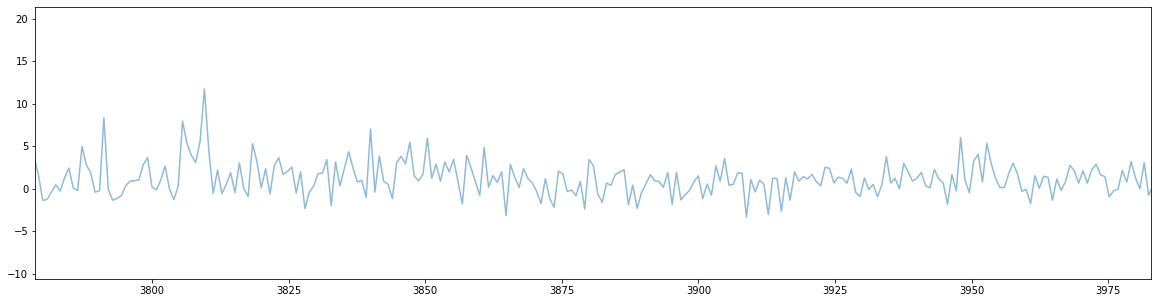

In [221]:
iobj = 3
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(specobj.wave['b'], specobj.flux['b'][iobj], alpha=0.5)
ax.plot(specobj.wave['r'], specobj.flux['r'][iobj],color ='tab:red', alpha=0.5)
ax.plot(specobj.wave['z'], specobj.flux['z'][iobj],color = 'tab:brown', alpha=0.5)
ax.set_xlim(np.array([3700, 3900]) * (1+zb[iobj]['Z']))
#ax.set_xlim(np.array([4950, 5050]) * (1+zb[iobj]['Z']))
#ax.set_xlim(np.array([6500, 6600]) * (1+zb[iobj]['Z']))

### Basic fitting

In [228]:
%time newflux = ssp.smooth_and_resample(specobj, zb, iobj=3, nproc=1)

CPU times: user 508 ms, sys: 885 ms, total: 1.39 s
Wall time: 2.88 s


In [232]:
len(newflux), specobj.wave['b'].shape

(7958, (2751,))

(3800.0, 4100.0)

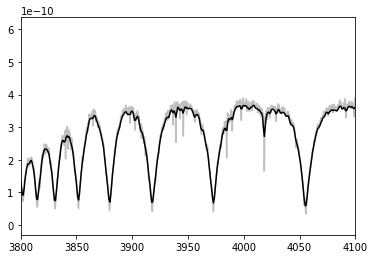

In [236]:
bigwave = np.hstack((specobj.wave['b'], specobj.wave['r'], specobj.wave['z']))
plt.plot(ssp.wave * (1+zb['Z'][iobj]), ssp.flux[:, 110], color='gray', alpha=0.5)
plt.plot(bigwave, newflux[:, 110], color='k')
plt.xlim(3800, 4100)
#plt.xlim(6000, 6100)
#plt.ylim(1e-10, 3e-10)

In [235]:
zb[iobj]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32
35191325326313983,9540.85826280713,666.5421739670386 .. 35.73752467606016,0.021251042067577414,3.521659506053375e-06,0,7928,GALAXY,,10,1343.1988827884197,0,1


### Spectral fitting

In [237]:
from fnnls import fnnls
#from numpy.linalg import lstsq as _lstsq
#from fnnls import RK
#RK1 = lambda Z, x: RK(Z, x)
#def RK1(Z, x):
#    return RK(Z, x)
#def lstsq(A, x):
#    return _lstsq(A, x, rcond=None)
#def __lstsq(A, x, weights=None):
#    return np.linalg.inv(A).dot(x)
#from scipy.optimize import least_squares
#def f(x, x0, A, gamma):
#    return A *gamma**2 / (gamma**2 + (x-x0)**2)

In [244]:
bigflux = np.hstack((specobj.flux['b'][iobj], specobj.flux['r'][iobj], specobj.flux['z'][iobj]))
bigivar = np.hstack((specobj.ivar['b'][iobj], specobj.ivar['r'][iobj], specobj.ivar['z'][iobj]))
%time coeff = fnnls(newflux, bigflux)[0]
#coeff

CPU times: user 22.8 ms, sys: 9.63 ms, total: 32.4 ms
Wall time: 16.9 ms


(4950.0, 5050.0)

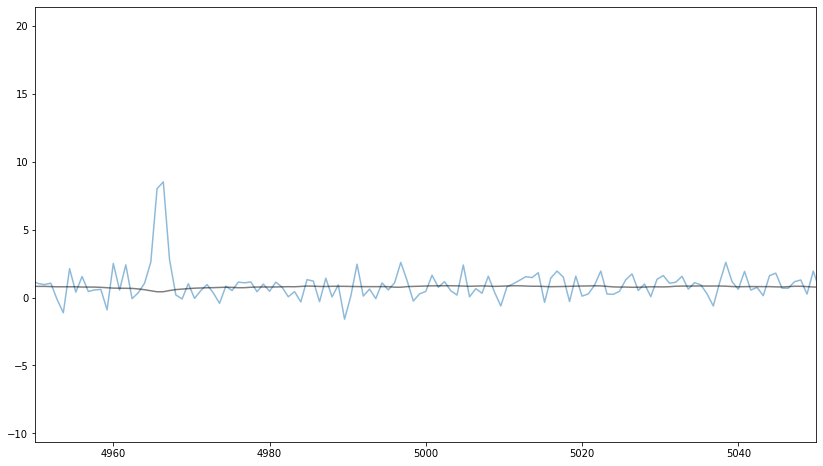

In [242]:
bestfit = newflux.dot(coeff)

fig, ax = plt.subplots(figsize=(14, 8))
#plt.plot(bigwave, bigflux, alpha=0.5)
ax.plot(specobj.wave['b'], specobj.flux['b'][iobj], alpha=0.5)
ax.plot(specobj.wave['r'], specobj.flux['r'][iobj],color ='tab:red', alpha=0.5)
ax.plot(specobj.wave['z'], specobj.flux['z'][iobj],color = 'tab:brown', alpha=0.5)

ax.plot(bigwave, bestfit, alpha=0.5, color='k')
#ax.set_xlim(3900, 4050)
ax.set_xlim(4950, 5050)

#### Next steps

* Write down a data model for the continuum and emission-line fitting results.

* Improved (iterative) continuum-fitting:
  - Implement weighted fitting.
  - Mask pixels around emission lines.
  - Update the continuum redshift using cross-correlation. 
  - Resample to constant log-lamba and solve for the velocity dispersion.
  - Need to be careful because several of these steps will be a function of S/N.
  - The last continuum fit should be a non-linear fit which includes dust attenuation.

* Generate the residual (emission-line) spectrum.
  - Instantiate an astropy.modeling class with the suite of strong emission lines.
  - Start with all the lines tied together then separate out the forbidden and recombination lines.

In [ ]:
stop

### Obsolete / sandbox below here

In [ ]:
class FSPSmodel(object):
    """initialize an FSPS StellarPopulation class. (relegated)
    
    """
    def __init__(self):
        import fsps
        self.ssp = fsps.StellarPopulation(
            zcontinuous=1,          # interpolate metallicities
            sfh=0,                  # 0=SSP; 4=delayed tau
            dust_type=0,            # 0=power law; 2=Calzetti+00
            dust_index=0.0,         # only used if dust_type=0
            imf_type=1)             # 0=Salpeter+55; 1=Chabrier+03
        
def _get_fsps_spec():
    tage = np.array([0.001, 0.05, 0.1, 0.3, 1.0, 5.0, 13.0])
    for ii, tt in enumerate(tage):
        wave, _spec = ssp.get_spectrum(tage=tt, peraa=True) # [Lsun/AA]
        if ii == 0:
            spec = np.zeros((len(tage), len(_spec)))
        spec[ii, :] = _spec
    return spec

#ssp = FSPSmodel().ssp
#plt.plot(wave, spec[5, :])
#plt.xlim(3000, 9000)